# Chapter 6 학습 관련 기술들

딥러닝 학습 효율, 정확도 개선 방법
- 가중치 매개변수 최적값 탐색하는 최적화 방법
- 가중치 매개변수 초깃값
- 하이퍼파라미터 설정 방법
- 오버피팅 대응책
    - 가중치 감소
    - 드롭아웃
- 배치 정규화

## 6.1 매개변수 갱신

신경망 학습의 목표는 매개변수의 최적값을 찾는 **최적화(optimization)**이다. 여태까지 사용한 최적화 방법으로 미분을 이용했는데 이 방법을 **확률적 경사 하강법(SGD)**라고 한다.

### 6.1.1 모험가 이야기 (생략)

### 6.1.2 확률적 경사 하강법(SGD)

- SGD 수식

$$W \leftarrow W - \eta \frac {\partial L} {\partial W}$$

In [1]:
class SGD:
    
    def __init__(self, lr=0.01):
        self.lr = lr
        
    
    def update(self, params, grads):
        for key in params.keys():
            params[key] -= self.lr * grads[key]

다음은 SGD 클래스를 사용하는 의사코드 예시이다.

```
network = TwoLayerNet(...)
optimizer = SGD()

for i in range(10000):
    ...
    x_batch, t_batch = get_mini_batch(...)
    grads = network.gradient(x_batch, t_batch)
    params = network.params
    optimizer.update(params, grads)
    ...
```

매개 변수 갱신은 optimizer가 책임을 지고 optimizer에 매개변수와 기울기 정보만 넘겨주면 된다. 여러 최적화 관련 클래스를 만들어 모듈화하면 다양한 방법으로 쉽게 최적화할 수 있다.

### 6.1.3 SGD의 단점

- 예시 함수

$$f(x, y) = \frac 1 {20} x^2 + y^2$$

<img src="https://mblogthumb-phinf.pstatic.net/MjAxNzA3MjdfMjU3/MDAxNTAxMTIxODU0MTYx.RZxiBW4kDiXReqK1UDxfBAffbM-pWJQwEI82m-evhucg.N_UhoBOXaCVYUPsP4wuoi4UUL1qQ_5iNEB000_QP1S4g.PNG.cjswo9207/fig_6-1.png?type=w2">
<center><small>▲ 그래프(왼쪽), 등고선(오른쪽)</small></center>

<img src="https://mblogthumb-phinf.pstatic.net/MjAxNzA3MjdfMTMx/MDAxNTAxMTIxOTIwOTE4.b5qnZS_a5u0UOQV16EQzWZpGXpmAkjKeqNVE8COqaNQg.sO1Li2aqIyVhpv3h1NfwLCuyqUfw9G1GZR-Nbsy0trgg.PNG.cjswo9207/fig_6-2.png?type=w2">
<center><small>▲ 기울기</small></center>

최솟값이 되는 위치는 $(x, y) = (0, 0)$이지만 대부분의 기울기는 $(0, 0)$을 가리키지 않는다.

<img src="https://mblogthumb-phinf.pstatic.net/MjAxNzA3MjdfMTU0/MDAxNTAxMTIyMDAwNTA1.E7zIAUXugKPAA5WiBXpF7HtATQ8nVjfBvJF-LJwqtsIg.52gqDjo2sPPup4Bfz5hOtp_b1svFcFItoYAJreHPp6Ag.PNG.cjswo9207/fig_6-3.png?type=w2">
<center><small>▲ SGD에 의한 최적화  갱신 경로</small></center>

- 비등방성 함수(방향에 따라 기울기가 달라지는 함수)에서 탐색 경로가 비효율적
- 근본 원인은 최솟값과 다른 방향을 가리키는 기울기

### 6.1.4 모멘텀(Momentum)

$$\mathbf{v} \leftarrow \alpha \mathbf{v} - \eta \frac {\partial L} {\partial W}$$
$$W \leftarrow W + \mathbf{v}$$

- $\mathbf{v}$: 속도
- 위의 첫번째 식은 기울기 방향으로 힘을 받아 물체가 가속된다는 물리 법칙을 나타낸다.
- $\alpha\mathbf{v}$: 물체가 아무런 힘을 받지 않을 때 서서히 하강시키는 역할

In [2]:
import numpy as np

In [3]:
class Momentum:
    
    def __init__(self, lr=0.01, momentum=0.9):
        self.lr = lr
        self.momentum = momentum
        self.v = None
        
    
    def update(self, params, grads):
        if self.v is None:
            self.v = {}
            for key, val in params.items():
                self.v[key] = np.zeros_like(val)
                
        for key in params.keys():
            self.v[key] = self.momentum*self.v[key] - self.lr*grads[key]
            params[key] += self.v[key]

<img src="https://mblogthumb-phinf.pstatic.net/MjAxNzA3MjdfMjQ5/MDAxNTAxMTIzNzcxMjY4.pW8LeX0QqcoQMI1qBQmpYf9skv8k0G2SBAqrmk_uP84g.CKPbYA_icOECAZXhBTB_g1qzmDRdtL3vUbEfbU4Y8yMg.PNG.cjswo9207/fig_6-5.png?type=w2">

<center><small>▲ 모멘텀에 의한 최적화 갱신 경로</small></center>

Q: 모멘텀 왜 이런 식으로 움직이는지?

SGD와 비교하면 지그재그가 덜 하다. 이유는 $x$축의 힘은 작지만 방향이 변하지 않아서 일정하게 가속하고 $y$축의 힘은 크지만 위아래로 번갈아 받아서 상충하여 $y$축 방향의 속도는 안정적이지 않기 때문이다.

### 6.1.5 AdaGrad 

**학습률 감소(learning rate decay)**  
학습을 진행하면서 학습률을 점차 줄여나가는 방법

AdaGrad는 개별 매개 변수에 적응적으로 학습률을 조정하면서 학습을 진행한다.

$$\mathbf{h} \leftarrow \mathbf{h} + \frac {\partial L} {\partial \mathbf{W}} \odot \frac {\partial L} {\partial \mathbf{W}}$$

$$\mathbf{W} \leftarrow \mathbf{W} - \eta \frac 1 {\sqrt{\mathbf{h}}} \frac {\partial L} {\partial \mathbf{W}}$$

- $\odot$: 행렬 원소별 곱셈
- $\mathbf{h}$: 기존 기울기 제곱해서 계속 더해주고 매개변수 갱신할 때 $\frac 1 {\sqrt{\mathbf{h}}}$로 학습률 조정
- 많이 움직인 원소의 학습률이 낮아짐

AdaGrad는 과거의 기울기의 제곱을 계속 누적해서 어느 순간 갱신량이 0이 되는 문제가 발생한다. 이를 개선한 기법으로 RMSProp이 있다. RMSProp은 지수이동평균을 이용해서 과거의 기울기를 서서히 잊고 새로운 기울기 정보를 더욱 크게 반영한다.

In [4]:
class AdaGrad:
    
    def __init__(self, lr=0.01):
        self.lr = lr
        self.h = None
        
    
    def update(self, params, grads):
        if self.h is None:
            self.h = {}
            for key, val in parmas.items():
                self.h[key] = np.zeros_like(val)
                
        for key in params.keys():
            self.h[key] += grads[key] * grads[key]
            params[key] -= self.lr * gras[key] / (np.sqrt(self.h[key]) + 1e-7)

1e-7을 더해주는 이유는 0으로 나누는 일을 막기 위함이다. 대분분의 딥러닝 프레임워크에서 이 값도 인수로 설정할 수 있다.

<img src="https://mblogthumb-phinf.pstatic.net/MjAxNzA3MjdfNDQg/MDAxNTAxMTI0NTczMDQz.1HzCY4kj0AqKMon65oOJdYfaIxGveuUjawHvH_XOtnkg.0Pf9RCSvNNbZiEqybl7EOt2b49lmHFcWSbFeBpnQG2Yg.PNG.cjswo9207/fig_6-6.png?type=w2">
<center><small>▲ AdaGrad에 의한 최적화 갱신 경로</small></center>

$y$축 방향은 기울기가 처음엔 크게 움직이지만, 이에 비례해서 갱신 정도도 빠르게 감소하기 때문에 지그재그 움직임이 줄어든다.

### 6.1.6 Adam

- 모멘텀과 AdaGrad를 융합한 것 같은 방법
- 편향 보정

<img src="https://mblogthumb-phinf.pstatic.net/MjAxNzA3MjdfMTY2/MDAxNTAxMTI0OTE5MzQz.uHy8VlKoQt9RgdMVQW0MZeae_puzDlTicctRfuKwwHIg.fET0kHfJPIXGMn261G-pdMItHWRM_hE6Y9tX2EMSa20g.PNG.cjswo9207/fig_6-7.png?type=w2">
<center><small>▲ Adam에 의한 최적화 갱신 경로</small></center>

Adam의 하이퍼파라미터
- 학습률 $\alpha$
- 일차 모멘텀용 계수 $\beta_1$: 0.9(기본값)
- 이차 모멘텀용 계수 $\beta_2$: 0.999(기본값)

### 6.1.7 어느 갱신 방법을 이용할 것인가?

위의 그래프들을 비교했을 때 AdaGrad가 가장 좋을 것 같지만 문제에 따라 다르다. 상황에 맞게 선택하는 것이 중요하다.

### 6.1.8 MNIST 데이터셋으로 본 갱신 방법 비교

In [7]:
# coding: utf-8
import os
import sys
sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.util import smooth_curve
from common.multi_layer_net import MultiLayerNet
from common.optimizer import *


# 0. MNIST 데이터 읽기==========
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

train_size = x_train.shape[0]
batch_size = 128
max_iterations = 2000


# 1. 실험용 설정==========
optimizers = {}
optimizers['SGD'] = SGD()
optimizers['Momentum'] = Momentum()
optimizers['AdaGrad'] = AdaGrad()
optimizers['Adam'] = Adam()
#optimizers['RMSprop'] = RMSprop()

networks = {}
train_loss = {}
for key in optimizers.keys():
    networks[key] = MultiLayerNet(
        input_size=784, hidden_size_list=[100, 100, 100, 100],
        output_size=10)
    train_loss[key] = []    


# 2. 훈련 시작==========
for i in range(max_iterations):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    for key in optimizers.keys():
        grads = networks[key].gradient(x_batch, t_batch)
        optimizers[key].update(networks[key].params, grads)
    
        loss = networks[key].loss(x_batch, t_batch)
        train_loss[key].append(loss)
    
    if i % 100 == 0:
        print( "===========" + "iteration:" + str(i) + "===========")
        for key in optimizers.keys():
            loss = networks[key].loss(x_batch, t_batch)
            print(key + ":" + str(loss))

===========iteration:0===========
SGD:2.386022328976163
Momentum:2.325051722982644
AdaGrad:2.2350241509485143
Adam:2.159313961607274
===========iteration:100===========
SGD:1.5766416224758655
Momentum:0.37118784168301044
AdaGrad:0.15807567353857488
Adam:0.25147446622700365
===========iteration:200===========
SGD:0.7366724091049136
Momentum:0.2129670452367987
AdaGrad:0.11707265270687384
Adam:0.17761081669615011
===========iteration:300===========
SGD:0.5206066741311849
Momentum:0.191149000098277
AdaGrad:0.05968834954068997
Adam:0.11617377023371435
===========iteration:400===========
SGD:0.43112144602858127
Momentum:0.14963171497282757
AdaGrad:0.05842741683378132
Adam:0.11284678355364522
===========iteration:500===========
SGD:0.31547097642267924
Momentum:0.10660304062347938
AdaGrad:0.05592231430397211
Adam:0.06487225660046124
===========iteration:600===========
SGD:0.31224629426547945
Momentum:0.11902589857647172
AdaGrad:0.044558063511723235
Adam:0.06623306961110037
===========iteration

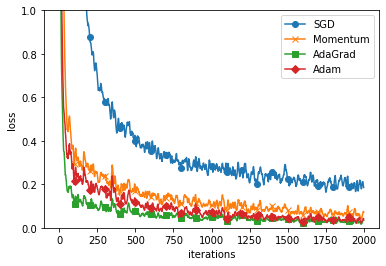

In [6]:
# 3. 그래프 그리기==========
markers = {"SGD": "o", "Momentum": "x", "AdaGrad": "s", "Adam": "D"}
x = np.arange(max_iterations)
for key in optimizers.keys():
    plt.plot(x, smooth_curve(train_loss[key]), marker=markers[key], markevery=100, label=key)
plt.xlabel("iterations")
plt.ylabel("loss")
plt.ylim(0, 1)
plt.legend()
plt.show()

## 6.2 가중치의 초깃값

### 6.2.1 초깃값을 0으로 하면?

가중치 감소(weight decay)
- 가중치 매개변수 값이 작아지도록 학습하는 방법
- 오버피팅 억제 효과

**가중치 초깃값을 0으로(균일한 값으로) 시작하면?**
- 올바른 학습 X
- 오차역전파법에서 모든 가중치 값이 똑같이 갱신되기 때문에
- **해결: 초깃값을 무작위로 설정**

### 6.2.2 은닉층의 활성화값 분포

시그모이드 함수를 활성화 함수로 사용하는 5층 신경망을 통해 실험
- 각 층의 뉴런은 100개
- 입력 데이터 수는 1000개
- 표준편차가 1인 정규분포 이용

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [26]:
x = np.random.randn(1000, 100)
node_num = 100
hidden_layer_size = 5
activations = {}

for i in range(hidden_layer_size):
    if i != 0:
        x = activations[i-1]
        
    w = np.random.randn(node_num, node_num) * 1
    a = np.dot(x, w)
    z = sigmoid(a)
    activations[i] = z

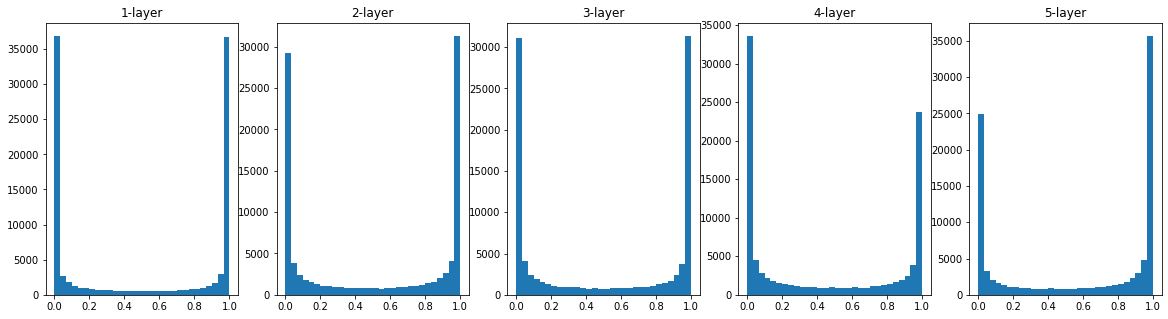

In [27]:
plt.figure(figsize=(20,5))
for i, a in activations.items():
    plt.subplot(1, len(activations), i+1)
    plt.title(str(i+1) + "-layer")
    plt.hist(a.flatten(), 30, range=(0,1))
plt.show()

- 활성화 값의 분포가 0, 1에 치우쳐져 있다.
- 시그모이드 함수는 0, 1에 가까워질 수록 미분값이 0에 가까워진다.
- 미분값이 0에 가까워지면 더 이상 갱신이 일어나지 않는 **기울기 소실(gradient vanishing)** 문제가 발생한다.

In [36]:
x = np.random.randn(1000, 100)
node_num = 100
hidden_layer_size = 5
activations = {}

for i in range(hidden_layer_size):
    if i != 0:
        x = activations[i-1]
        
    w = np.random.randn(node_num, node_num) * 0.01
    a = np.dot(x, w)
    z = sigmoid(a)
    activations[i] = z

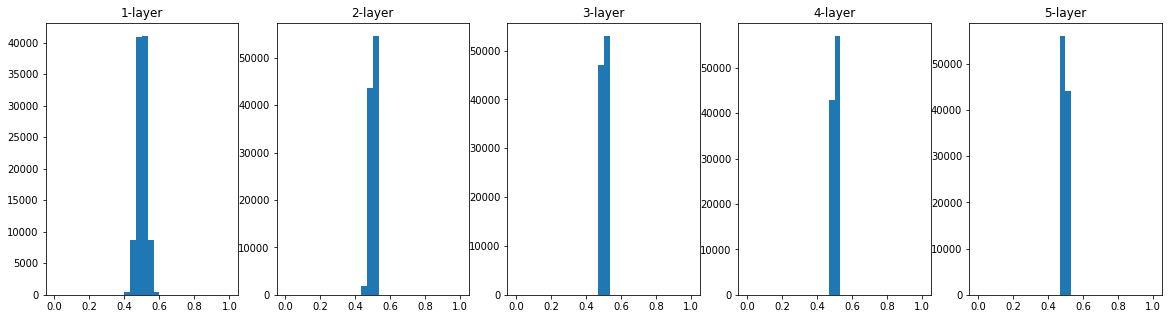

In [37]:
plt.figure(figsize=(20,5))
for i, a in activations.items():
    plt.subplot(1, len(activations), i+1)
    plt.title(str(i+1) + "-layer")
    plt.hist(a.flatten(), 30, range=(0,1))
plt.show()

In [38]:
activations

{0: array([[0.47510529, 0.5337012 , 0.50246425, ..., 0.53564721, 0.51806879,
         0.52973781],
        [0.48389798, 0.49156359, 0.5004307 , ..., 0.47501203, 0.50423051,
         0.481287  ],
        [0.45297996, 0.49237966, 0.47288158, ..., 0.45614095, 0.44685061,
         0.50093314],
        ...,
        [0.48098354, 0.50503036, 0.50289379, ..., 0.48413844, 0.5159619 ,
         0.51706842],
        [0.50609917, 0.54160537, 0.47694298, ..., 0.50507099, 0.50068575,
         0.48808848],
        [0.52785112, 0.50274475, 0.50429485, ..., 0.48173126, 0.52671102,
         0.49431768]]),
 1: array([[0.48001208, 0.47977019, 0.50622738, ..., 0.48648041, 0.52498678,
         0.5052194 ],
        [0.48087855, 0.48119919, 0.50589301, ..., 0.48710548, 0.524929  ,
         0.50659169],
        [0.48089019, 0.47950954, 0.50513487, ..., 0.48614814, 0.52541495,
         0.5052187 ],
        ...,
        [0.48043455, 0.48054057, 0.50529645, ..., 0.48716627, 0.52480393,
         0.50565974],
      

표준편차가 0.01인 정규분포의 활성화값 분포
- 0.5 근처에 분포
- 기울기 소실 문제는 발생하지 않는다.
- 대부분의 활성화 값이 0.5 근처에 분포해서 뉴런을 여러 개 둔 의미가 상실된다.
- **표현력을 제한한다.**

**Xavier 초깃값**
- 각 층의 활성화값들을 광범위하게 분포시킬 목적
- 앞 계층의 노드가 $n$개라면 표준편차가 $\frac 1 {\sqrt n}$인 분포 사용
- 앞 층의 노드수가 많을 수록 대상 노드의 초깃값으로 설정하는 가중치가 좁게 퍼짐

In [30]:
x = np.random.randn(1000, 100)
node_num = 100
hidden_layer_size = 5
activations = {}

for i in range(hidden_layer_size):
    if i != 0:
        x = activations[i-1]
        
    w = np.random.randn(node_num, node_num) / np.sqrt(node_num)
    a = np.dot(x, w)
    z = sigmoid(a)
    activations[i] = z

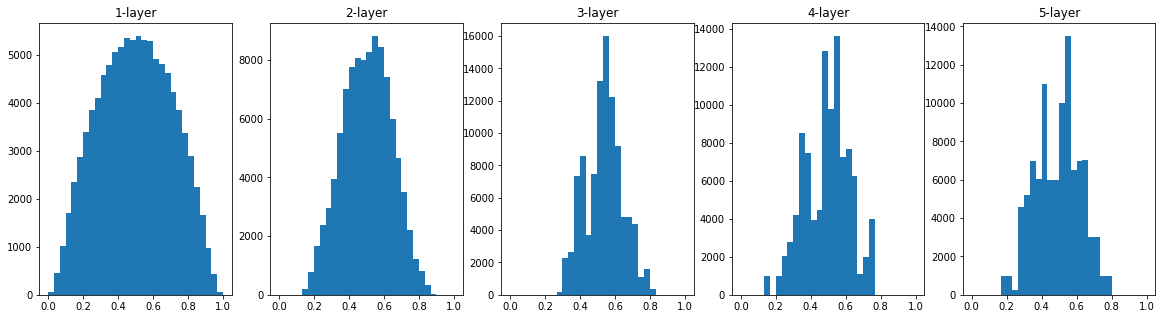

In [31]:
plt.figure(figsize=(20,5))
for i, a in activations.items():
    plt.subplot(1, len(activations), i+1)
    plt.title(str(i+1) + "-layer")
    plt.hist(a.flatten(), 30, range=(0,1))
plt.show()

- 앞의 방식들보다 넓게 분포
- 층이 깊어질수록 형태가 다소 일그러짐, 이는 시그모이드 함수가 (0, 0.5)에서 대칭인 S 곡선이기 때문이다. tanh를 사용하면 해결 가능

In [62]:
def tanh(x):
    return np.tanh(x)

In [63]:
x = np.random.randn(1000, 100)
node_num = 100
hidden_layer_size = 5
activations = {}

for i in range(hidden_layer_size):
    if i != 0:
        x = activations[i-1]
        
    w = np.random.randn(node_num, node_num) / np.sqrt(node_num)
    a = np.dot(x, w)
    z = tanh(a)
    activations[i] = z

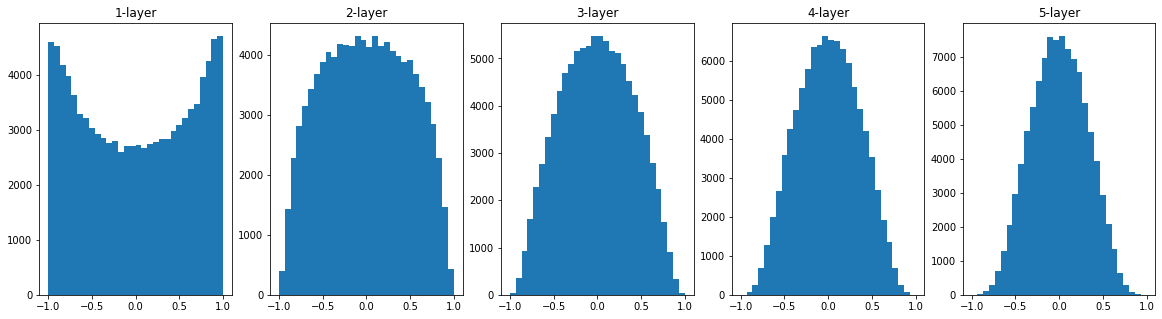

In [64]:
plt.figure(figsize=(20,5))
for i, a in activations.items():
    plt.subplot(1, len(activations), i+1)
    plt.title(str(i+1) + "-layer")
    plt.hist(a.flatten(), 30, range=(-1,1))
plt.show()

활성화 함수로 tanh를 사용
- 시그모이드를 사용했을 때보다 깔끔한 종 모양
- Xavier 초깃값은 원점에서 대칭인 함수가 바람직하다.

### 6.2.3 ReLU를 사용할 때의 가중치 초깃값

- RelU에 적합한 초깃값 이용 권장: **He 초깃값**
- 앞 계층의 노드가 $n$개일 때, 표준편차가 $\sqrt{\frac 2 n}$인 정규분포 사용
- ReLU의 반이 0이라서 더 넓게 분포시키기 위해서 2배의 계수가 필요

In [65]:
def relu(x):
    return np.maximum(0, x)

In [72]:
x = np.random.randn(1000, 100)
node_num = 100
hidden_layer_size = 5
activations = {}

for i in range(hidden_layer_size):
    if i != 0:
        x = activations[i-1]
        
    w = np.random.randn(node_num, node_num) * 0.01
    a = np.dot(x, w)
    z = relu(a)
    activations[i] = z

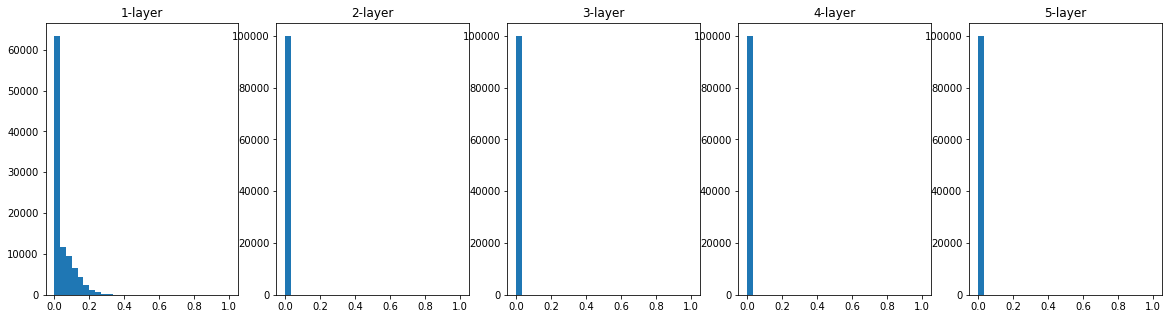

In [74]:
plt.figure(figsize=(20,5))
for i, a in activations.items():
    plt.subplot(1, len(activations), i+1)
    plt.title(str(i+1) + "-layer")
    plt.hist(a.flatten(), 30, range=(0,1))
plt.show()

표준편차가 0.01인 정규분포를  가중치 초깃값으로 사용한 경우
- 학습이 거의 이뤄지지 않음

In [68]:
x = np.random.randn(1000, 100)
node_num = 100
hidden_layer_size = 5
activations = {}

for i in range(hidden_layer_size):
    if i != 0:
        x = activations[i-1]
        
    w = np.random.randn(node_num, node_num) / np.sqrt(node_num)
    a = np.dot(x, w)
    z = relu(a)
    activations[i] = z

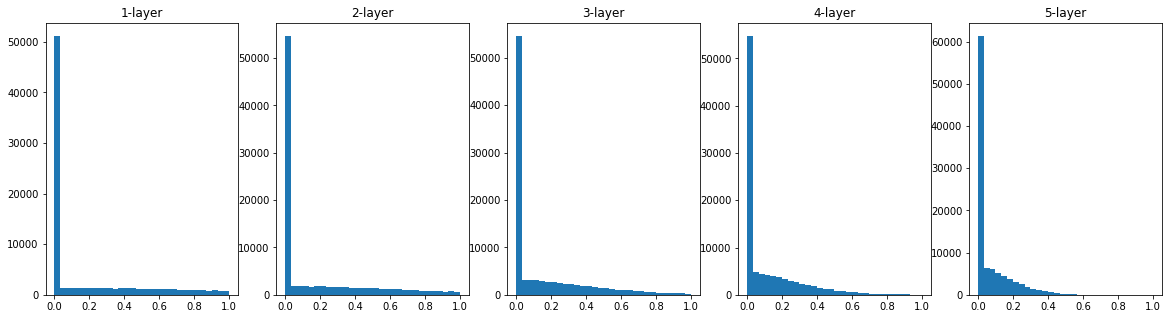

In [69]:
plt.figure(figsize=(20,5))
for i, a in activations.items():
    plt.subplot(1, len(activations), i+1)
    plt.title(str(i+1) + "-layer")
    plt.hist(a.flatten(), 30, range=(0,1))
plt.show()

Xavier 초깃값을 사용한 경우
- 활성화 값들의 치우침도 커지고, 기울기 소실 문제도 발생

In [70]:
x = np.random.randn(1000, 100)
node_num = 100
hidden_layer_size = 5
activations = {}

for i in range(hidden_layer_size):
    if i != 0:
        x = activations[i-1]
        
    w = np.random.randn(node_num, node_num) * np.sqrt(2.0 / node_num)
    a = np.dot(x, w)
    z = relu(a)
    activations[i] = z

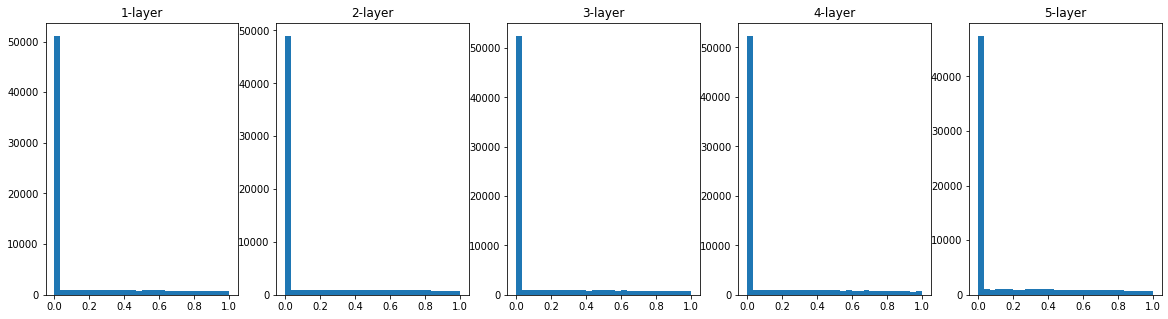

In [58]:
plt.figure(figsize=(20,5))
for i, a in activations.items():
    plt.subplot(1, len(activations), i+1)
    plt.title(str(i+1) + "-layer")
    plt.hist(a.flatten(), 30, range=(0,1))
plt.show()

He 초깃값을 사용한 경우
- 모든 층에서 균일하게 분포

결론
- ReLU: He 초깃값
- S자 활성화 함수: Xavier 초깃값

### 6.2.4 MNIST 데이터셋으로 본 가중치 초깃값 비교

===========iteration:0===========
std=0.01:2.3024417737762706
Xavier:2.2973890617430257
He:2.2945591097152347
===========iteration:100===========
std=0.01:2.3027896977653146
Xavier:2.23479865097156
He:1.51911031384046
===========iteration:200===========
std=0.01:2.301854190059992
Xavier:2.0488278846372596
He:0.7731610078069331
===========iteration:300===========
std=0.01:2.3002685845882724
Xavier:1.624593392109387
He:0.48322189989683617
===========iteration:400===========
std=0.01:2.301779573089194
Xavier:1.2566912564051238
He:0.4761604288970381
===========iteration:500===========
std=0.01:2.3008422035252916
Xavier:0.7884394825438645
He:0.2693866178176782
===========iteration:600===========
std=0.01:2.305408399184437
Xavier:0.7115055035228819
He:0.2819126647719926
===========iteration:700===========
std=0.01:2.3036593953265943
Xavier:0.5481567455319118
He:0.24716772652726085
===========iteration:800===========
std=0.01:2.3008972565704324
Xavier:0.5172022371357116
He:0.35389504089769586

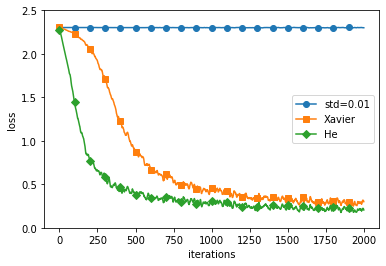

In [75]:
# coding: utf-8
import os
import sys

sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.util import smooth_curve
from common.multi_layer_net import MultiLayerNet
from common.optimizer import SGD


# 0. MNIST 데이터 읽기==========
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

train_size = x_train.shape[0]
batch_size = 128
max_iterations = 2000


# 1. 실험용 설정==========
weight_init_types = {'std=0.01': 0.01, 'Xavier': 'sigmoid', 'He': 'relu'}
optimizer = SGD(lr=0.01)

networks = {}
train_loss = {}
for key, weight_type in weight_init_types.items():
    networks[key] = MultiLayerNet(input_size=784, hidden_size_list=[100, 100, 100, 100],
                                  output_size=10, weight_init_std=weight_type)
    train_loss[key] = []


# 2. 훈련 시작==========
for i in range(max_iterations):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    for key in weight_init_types.keys():
        grads = networks[key].gradient(x_batch, t_batch)
        optimizer.update(networks[key].params, grads)
    
        loss = networks[key].loss(x_batch, t_batch)
        train_loss[key].append(loss)
    
    if i % 100 == 0:
        print("===========" + "iteration:" + str(i) + "===========")
        for key in weight_init_types.keys():
            loss = networks[key].loss(x_batch, t_batch)
            print(key + ":" + str(loss))


# 3. 그래프 그리기==========
markers = {'std=0.01': 'o', 'Xavier': 's', 'He': 'D'}
x = np.arange(max_iterations)
for key in weight_init_types.keys():
    plt.plot(x, smooth_curve(train_loss[key]), marker=markers[key], markevery=100, label=key)
plt.xlabel("iterations")
plt.ylabel("loss")
plt.ylim(0, 2.5)
plt.legend()
plt.show()

## 6.3 배치 정규화

### 6.3.1 배치 정규화 알고리즘

배치 정규화가 주목받는 이유
- 학습 속도 개선
- 초깃값에 크게 의존하지 않는다.
- 오버피팅 억제

배치 정규화(batch normalization)
- 학습 시 미니배치 단위로 정규화
- 각 층에서의 활성화값이 적당히 분포되도록 강제한다.
- 신경망 중간에 배치 정규화 계층을 삽입
<img src="https://t1.daumcdn.net/cfile/tistory/997AE03A5AAAA64C2A">
- 수식
$$\mu_B \leftarrow \frac 1 m \sum^m_{i=1} x_i$$

$$\sigma^2_B \leftarrow \sum^m_{i=1} (x_i - \mu_B)^2$$

$$\hat {x}_i \leftarrow \frac {x_i - \mu_B} {\sqrt {\sigma^2_B + \epsilon}}$$
- 미니 배치의 평균이 0, 분산이 1이 되도록 정규화
- $\epsilon$은 0으로 나누는 것을 방지(10e-7과 같은 매우 작은 값 사용)
- 활성화 함수 앞이나 뒤에 삽입
- 배치 정규화 계층마다 정규화된 데이터에 고유한 확대와 이동 변환을 수행한다.
$$y_i \leftarrow \gamma \hat{x}_i + \beta$$
- $\gamma$: 확대, $\beta$: 이동
<img src="https://mblogthumb-phinf.pstatic.net/MjAxNzA3MjdfMjYx/MDAxNTAxMTI5MDU1Mzg0.lsuyZE7qxn42sz10-EPOhwx0pTaXF9X0o8UCjI4LDS8g.nl-o2tc5upQvairyHQUU1RjZg5aUz2e9xu5KfbIHjBwg.PNG.cjswo9207/fig_6-17.png?type=w2">
<center><small>▲ 배치 정규화 계산 그래프</small></center>

### 6.3.2 배치 정규화의 효과

MNIST 데이터셋을 사용하여 비교

In [ ]:
# coding: utf-8
import sys, os
sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.multi_layer_net_extend import MultiLayerNetExtend
from common.optimizer import SGD, Adam

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

# 학습 데이터를 줄임
x_train = x_train[:1000]
t_train = t_train[:1000]

max_epochs = 20
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.01


def __train(weight_init_std):
    bn_network = MultiLayerNetExtend(input_size=784, hidden_size_list=[100, 100, 100, 100, 100], output_size=10, 
                                    weight_init_std=weight_init_std, use_batchnorm=True)
    network = MultiLayerNetExtend(input_size=784, hidden_size_list=[100, 100, 100, 100, 100], output_size=10,
                                weight_init_std=weight_init_std)
    optimizer = SGD(lr=learning_rate)
    
    train_acc_list = []
    bn_train_acc_list = []
    
    iter_per_epoch = max(train_size / batch_size, 1)
    epoch_cnt = 0
    
    for i in range(1000000000):
        batch_mask = np.random.choice(train_size, batch_size)
        x_batch = x_train[batch_mask]
        t_batch = t_train[batch_mask]
    
        for _network in (bn_network, network):
            grads = _network.gradient(x_batch, t_batch)
            optimizer.update(_network.params, grads)
    
        if i % iter_per_epoch == 0:
            train_acc = network.accuracy(x_train, t_train)
            bn_train_acc = bn_network.accuracy(x_train, t_train)
            train_acc_list.append(train_acc)
            bn_train_acc_list.append(bn_train_acc)
    
            print("epoch:" + str(epoch_cnt) + " | " + str(train_acc) + " - " + str(bn_train_acc))
    
            epoch_cnt += 1
            if epoch_cnt >= max_epochs:
                break
                
    return train_acc_list, bn_train_acc_list

============== 1/16 ==============
epoch:0 | 0.093 - 0.11
epoch:1 | 0.097 - 0.093


C:\Users\KJK\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


epoch:2 | 0.097 - 0.11
epoch:3 | 0.097 - 0.146
epoch:4 | 0.097 - 0.163
epoch:5 | 0.097 - 0.18
epoch:6 | 0.097 - 0.209
epoch:7 | 0.097 - 0.229
epoch:8 | 0.097 - 0.238
epoch:9 | 0.097 - 0.264
epoch:10 | 0.097 - 0.28
epoch:11 | 0.097 - 0.299
epoch:12 | 0.097 - 0.32
epoch:13 | 0.097 - 0.34
epoch:14 | 0.097 - 0.358
epoch:15 | 0.097 - 0.371
epoch:16 | 0.097 - 0.381
epoch:17 | 0.097 - 0.393


No handles with labels found to put in legend.


epoch:18 | 0.097 - 0.421
epoch:19 | 0.097 - 0.423
============== 2/16 ==============
epoch:0 | 0.094 - 0.075
epoch:1 | 0.097 - 0.144
epoch:2 | 0.097 - 0.149
epoch:3 | 0.097 - 0.171
epoch:4 | 0.097 - 0.201
epoch:5 | 0.097 - 0.223
epoch:6 | 0.097 - 0.259
epoch:7 | 0.097 - 0.288
epoch:8 | 0.097 - 0.315
epoch:9 | 0.097 - 0.332
epoch:10 | 0.097 - 0.365
epoch:11 | 0.097 - 0.386
epoch:12 | 0.097 - 0.402
epoch:13 | 0.097 - 0.421
epoch:14 | 0.097 - 0.439
epoch:15 | 0.097 - 0.463
epoch:16 | 0.097 - 0.476
epoch:17 | 0.097 - 0.488


No handles with labels found to put in legend.


epoch:18 | 0.097 - 0.495
epoch:19 | 0.097 - 0.512
============== 3/16 ==============
epoch:0 | 0.133 - 0.085
epoch:1 | 0.371 - 0.113
epoch:2 | 0.538 - 0.171
epoch:3 | 0.604 - 0.242
epoch:4 | 0.699 - 0.281
epoch:5 | 0.759 - 0.316
epoch:6 | 0.795 - 0.35
epoch:7 | 0.834 - 0.371
epoch:8 | 0.859 - 0.407
epoch:9 | 0.889 - 0.43
epoch:10 | 0.92 - 0.464
epoch:11 | 0.937 - 0.474
epoch:12 | 0.947 - 0.513
epoch:13 | 0.962 - 0.521
epoch:14 | 0.97 - 0.555
epoch:15 | 0.973 - 0.574
epoch:16 | 0.977 - 0.592
epoch:17 | 0.977 - 0.607
epoch:18 | 0.984 - 0.616


No handles with labels found to put in legend.


epoch:19 | 0.984 - 0.634
============== 4/16 ==============
epoch:0 | 0.069 - 0.09
epoch:1 | 0.253 - 0.106
epoch:2 | 0.367 - 0.199
epoch:3 | 0.438 - 0.276
epoch:4 | 0.522 - 0.345
epoch:5 | 0.561 - 0.401
epoch:6 | 0.612 - 0.457
epoch:7 | 0.656 - 0.502
epoch:8 | 0.707 - 0.547
epoch:9 | 0.731 - 0.581
epoch:10 | 0.762 - 0.61
epoch:11 | 0.765 - 0.636
epoch:12 | 0.78 - 0.664
epoch:13 | 0.803 - 0.697
epoch:14 | 0.814 - 0.711
epoch:15 | 0.822 - 0.732
epoch:16 | 0.836 - 0.75
epoch:17 | 0.839 - 0.758


No handles with labels found to put in legend.


epoch:18 | 0.85 - 0.774
epoch:19 | 0.861 - 0.792
============== 5/16 ==============
epoch:0 | 0.097 - 0.118
epoch:1 | 0.097 - 0.255
epoch:2 | 0.097 - 0.379
epoch:3 | 0.097 - 0.479
epoch:4 | 0.097 - 0.554
epoch:5 | 0.097 - 0.611
epoch:6 | 0.097 - 0.648
epoch:7 | 0.097 - 0.682
epoch:8 | 0.097 - 0.711
epoch:9 | 0.099 - 0.747
epoch:10 | 0.1 - 0.766
epoch:11 | 0.099 - 0.787
epoch:12 | 0.1 - 0.808
epoch:13 | 0.1 - 0.825
epoch:14 | 0.1 - 0.833
epoch:15 | 0.101 - 0.857
epoch:16 | 0.102 - 0.864
epoch:17 | 0.109 - 0.877
epoch:18 | 0.11 - 0.884


No handles with labels found to put in legend.


epoch:19 | 0.113 - 0.895
============== 6/16 ==============
epoch:0 | 0.11 - 0.105
epoch:1 | 0.141 - 0.212
epoch:2 | 0.119 - 0.477
epoch:3 | 0.118 - 0.624
epoch:4 | 0.116 - 0.681
epoch:5 | 0.116 - 0.734
epoch:6 | 0.116 - 0.76
epoch:7 | 0.116 - 0.793
epoch:8 | 0.116 - 0.813
epoch:9 | 0.142 - 0.831
epoch:10 | 0.178 - 0.846
epoch:11 | 0.205 - 0.866
epoch:12 | 0.134 - 0.878
epoch:13 | 0.18 - 0.905
epoch:14 | 0.152 - 0.918
epoch:15 | 0.116 - 0.931
epoch:16 | 0.13 - 0.94
epoch:17 | 0.116 - 0.942


No handles with labels found to put in legend.


epoch:18 | 0.116 - 0.946
epoch:19 | 0.116 - 0.955
============== 7/16 ==============
epoch:0 | 0.105 - 0.124
epoch:1 | 0.117 - 0.321
epoch:2 | 0.117 - 0.598
epoch:3 | 0.117 - 0.733
epoch:4 | 0.117 - 0.782
epoch:5 | 0.117 - 0.809
epoch:6 | 0.117 - 0.825
epoch:7 | 0.117 - 0.862
epoch:8 | 0.117 - 0.892
epoch:9 | 0.117 - 0.915
epoch:10 | 0.117 - 0.928
epoch:11 | 0.117 - 0.945
epoch:12 | 0.117 - 0.958
epoch:13 | 0.117 - 0.971
epoch:14 | 0.117 - 0.975
epoch:15 | 0.117 - 0.981
epoch:16 | 0.117 - 0.983
epoch:17 | 0.117 - 0.987
epoch:18 | 0.117 - 0.984


No handles with labels found to put in legend.


epoch:19 | 0.117 - 0.986
============== 8/16 ==============
epoch:0 | 0.097 - 0.099
epoch:1 | 0.117 - 0.325
epoch:2 | 0.117 - 0.692
epoch:3 | 0.117 - 0.788
epoch:4 | 0.117 - 0.851
epoch:5 | 0.117 - 0.904
epoch:6 | 0.117 - 0.923
epoch:7 | 0.117 - 0.954
epoch:8 | 0.117 - 0.967
epoch:9 | 0.117 - 0.984
epoch:10 | 0.117 - 0.984
epoch:11 | 0.117 - 0.99
epoch:12 | 0.117 - 0.993
epoch:13 | 0.117 - 0.994
epoch:14 | 0.117 - 0.995
epoch:15 | 0.117 - 0.994
epoch:16 | 0.117 - 0.996
epoch:17 | 0.117 - 0.996


No handles with labels found to put in legend.


epoch:18 | 0.117 - 0.999
epoch:19 | 0.117 - 0.999
============== 9/16 ==============
epoch:0 | 0.116 - 0.104
epoch:1 | 0.116 - 0.48
epoch:2 | 0.116 - 0.678
epoch:3 | 0.116 - 0.73
epoch:4 | 0.116 - 0.795
epoch:5 | 0.116 - 0.846
epoch:6 | 0.116 - 0.876
epoch:7 | 0.116 - 0.898
epoch:8 | 0.116 - 0.932
epoch:9 | 0.116 - 0.979
epoch:10 | 0.116 - 0.991
epoch:11 | 0.116 - 0.997
epoch:12 | 0.116 - 0.997
epoch:13 | 0.116 - 0.999
epoch:14 | 0.116 - 1.0
epoch:15 | 0.116 - 1.0
epoch:16 | 0.116 - 1.0
epoch:17 | 0.116 - 1.0


No handles with labels found to put in legend.


epoch:18 | 0.116 - 1.0
epoch:19 | 0.116 - 1.0
============== 10/16 ==============
epoch:0 | 0.099 - 0.166
epoch:1 | 0.117 - 0.784
epoch:2 | 0.105 - 0.879
epoch:3 | 0.117 - 0.928
epoch:4 | 0.117 - 0.947
epoch:5 | 0.117 - 0.92
epoch:6 | 0.117 - 0.971
epoch:7 | 0.117 - 0.97
epoch:8 | 0.117 - 0.987
epoch:9 | 0.117 - 0.979
epoch:10 | 0.117 - 0.982
epoch:11 | 0.117 - 0.986
epoch:12 | 0.117 - 0.991
epoch:13 | 0.117 - 0.996
epoch:14 | 0.117 - 0.996
epoch:15 | 0.117 - 0.996
epoch:16 | 0.117 - 0.997
epoch:17 | 0.117 - 0.997
epoch:18 | 0.117 - 0.995


No handles with labels found to put in legend.


epoch:19 | 0.117 - 0.997
============== 11/16 ==============
epoch:0 | 0.117 - 0.168
epoch:1 | 0.105 - 0.629
epoch:2 | 0.116 - 0.629
epoch:3 | 0.116 - 0.76
epoch:4 | 0.116 - 0.751
epoch:5 | 0.116 - 0.837
epoch:6 | 0.116 - 0.853
epoch:7 | 0.116 - 0.889
epoch:8 | 0.116 - 0.961
epoch:9 | 0.116 - 0.948
epoch:10 | 0.116 - 0.974
epoch:11 | 0.116 - 0.977
epoch:12 | 0.116 - 0.988
epoch:13 | 0.116 - 0.99
epoch:14 | 0.116 - 0.989
epoch:15 | 0.116 - 0.994
epoch:16 | 0.116 - 0.993
epoch:17 | 0.116 - 0.993
epoch:18 | 0.116 - 0.992

No handles with labels found to put in legend.



epoch:19 | 0.116 - 0.995
============== 12/16 ==============
epoch:0 | 0.094 - 0.15
epoch:1 | 0.116 - 0.529
epoch:2 | 0.117 - 0.643
epoch:3 | 0.117 - 0.7
epoch:4 | 0.117 - 0.755
epoch:5 | 0.117 - 0.824
epoch:6 | 0.117 - 0.866
epoch:7 | 0.117 - 0.877
epoch:8 | 0.116 - 0.885
epoch:9 | 0.116 - 0.888
epoch:10 | 0.116 - 0.892
epoch:11 | 0.116 - 0.942
epoch:12 | 0.117 - 0.978
epoch:13 | 0.117 - 0.986
epoch:14 | 0.117 - 0.988
epoch:15 | 0.116 - 0.988
epoch:16 | 0.116 - 0.99
epoch:17 | 0.116 - 0.99
epoch:18 | 0.116 - 0.993


No handles with labels found to put in legend.


epoch:19 | 0.116 - 0.993
============== 13/16 ==============
epoch:0 | 0.099 - 0.166
epoch:1 | 0.116 - 0.407
epoch:2 | 0.116 - 0.566
epoch:3 | 0.116 - 0.594
epoch:4 | 0.116 - 0.626
epoch:5 | 0.116 - 0.612
epoch:6 | 0.116 - 0.609
epoch:7 | 0.116 - 0.616
epoch:8 | 0.116 - 0.621
epoch:9 | 0.116 - 0.622
epoch:10 | 0.116 - 0.708
epoch:11 | 0.116 - 0.678
epoch:12 | 0.116 - 0.445
epoch:13 | 0.116 - 0.766
epoch:14 | 0.116 - 0.779
epoch:15 | 0.116 - 0.798
epoch:16 | 0.116 - 0.791
epoch:17 | 0.116 - 0.807


No handles with labels found to put in legend.


epoch:18 | 0.116 - 0.807
epoch:19 | 0.116 - 0.811
============== 14/16 ==============
epoch:0 | 0.116 - 0.097
epoch:1 | 0.117 - 0.368
epoch:2 | 0.117 - 0.419
epoch:3 | 0.117 - 0.423
epoch:4 | 0.117 - 0.426
epoch:5 | 0.117 - 0.49
epoch:6 | 0.117 - 0.447
epoch:7 | 0.117 - 0.487
epoch:8 | 0.117 - 0.499
epoch:9 | 0.117 - 0.484
epoch:10 | 0.117 - 0.507
epoch:11 | 0.117 - 0.49
epoch:12 | 0.117 - 0.527
epoch:13 | 0.117 - 0.526
epoch:14 | 0.117 - 0.527
epoch:15 | 0.117 - 0.492
epoch:16 | 0.117 - 0.497
epoch:17 | 0.117 - 0.527
epoch:18 | 0.117 - 0.503


No handles with labels found to put in legend.


epoch:19 | 0.117 - 0.53
============== 15/16 ==============
epoch:0 | 0.116 - 0.097
epoch:1 | 0.116 - 0.284
epoch:2 | 0.116 - 0.408
epoch:3 | 0.116 - 0.406
epoch:4 | 0.116 - 0.413
epoch:5 | 0.116 - 0.406
epoch:6 | 0.116 - 0.413
epoch:7 | 0.116 - 0.465
epoch:8 | 0.116 - 0.505
epoch:9 | 0.116 - 0.479
epoch:10 | 0.116 - 0.497
epoch:11 | 0.117 - 0.519
epoch:12 | 0.117 - 0.519
epoch:13 | 0.117 - 0.52
epoch:14 | 0.117 - 0.521
epoch:15 | 0.117 - 0.521
epoch:16 | 0.116 - 0.52
epoch:17 | 0.116 - 0.523
epoch:18 | 0.116 - 0.523


No handles with labels found to put in legend.


epoch:19 | 0.116 - 0.493
============== 16/16 ==============
epoch:0 | 0.117 - 0.192
epoch:1 | 0.117 - 0.211
epoch:2 | 0.116 - 0.354
epoch:3 | 0.116 - 0.388
epoch:4 | 0.116 - 0.393
epoch:5 | 0.116 - 0.391
epoch:6 | 0.116 - 0.384
epoch:7 | 0.116 - 0.397
epoch:8 | 0.116 - 0.399
epoch:9 | 0.116 - 0.406
epoch:10 | 0.116 - 0.41
epoch:11 | 0.116 - 0.414
epoch:12 | 0.116 - 0.421
epoch:13 | 0.116 - 0.421
epoch:14 | 0.116 - 0.42
epoch:15 | 0.116 - 0.421
epoch:16 | 0.116 - 0.506
epoch:17 | 0.116 - 0.509
epoch:18 | 0.116 - 0.512
epoch:19 | 0.116 - 0.511


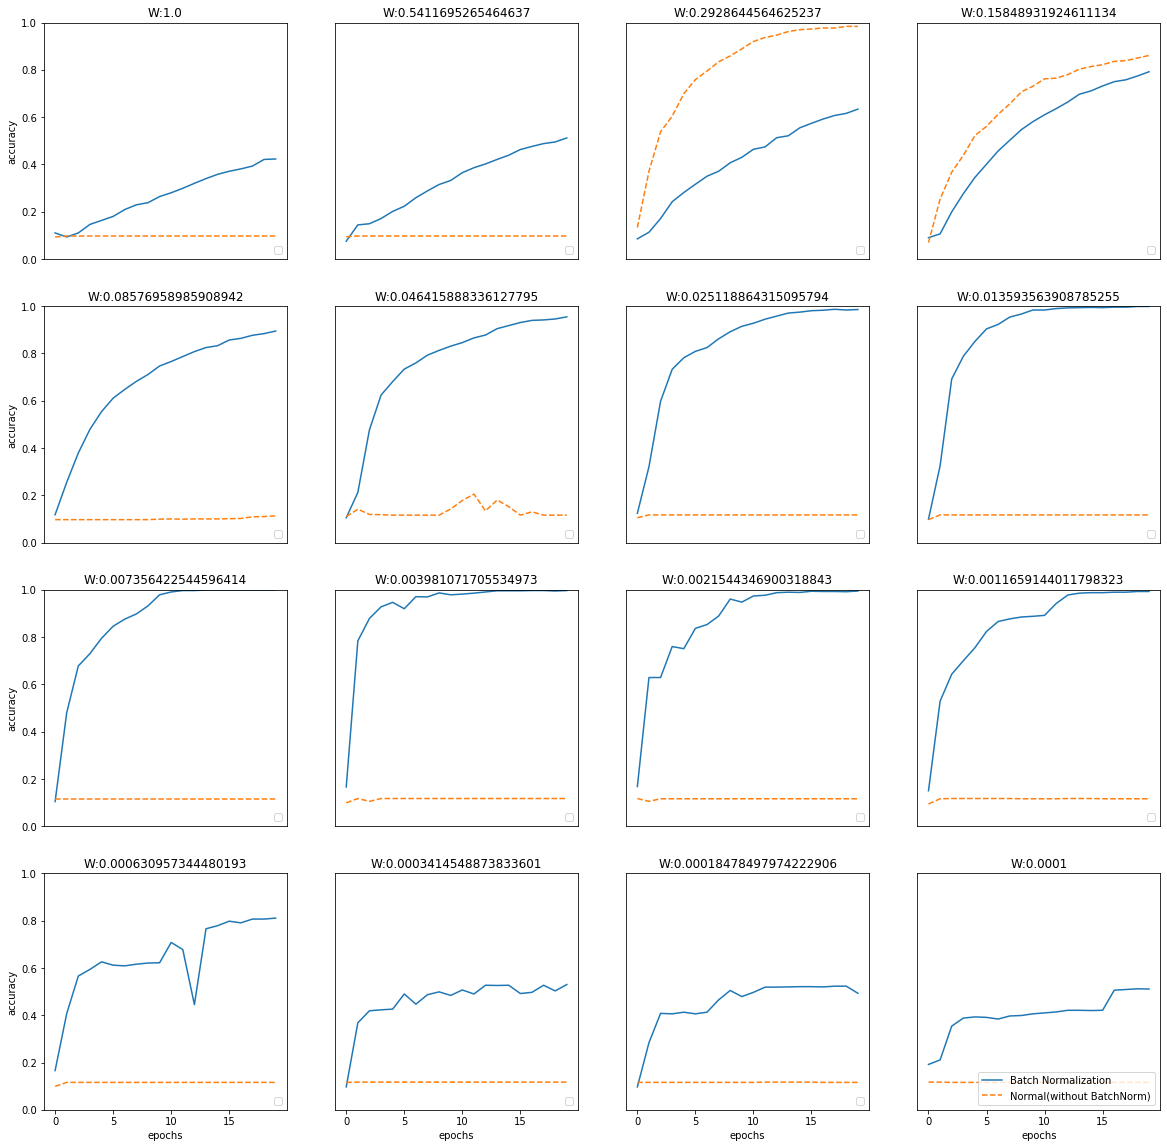

In [78]:
# 그래프 그리기==========
weight_scale_list = np.logspace(0, -4, num=16)
x = np.arange(max_epochs)

plt.figure(figsize=(20,20))
for i, w in enumerate(weight_scale_list):
    print( "============== " + str(i+1) + "/16" + " ==============")
    train_acc_list, bn_train_acc_list = __train(w)
    
    plt.subplot(4,4,i+1)
    plt.title("W:" + str(w))
    if i == 15:
        plt.plot(x, bn_train_acc_list, label='Batch Normalization', markevery=2)
        plt.plot(x, train_acc_list, linestyle = "--", label='Normal(without BatchNorm)', markevery=2)
    else:
        plt.plot(x, bn_train_acc_list, markevery=2)
        plt.plot(x, train_acc_list, linestyle="--", markevery=2)

    plt.ylim(0, 1.0)
    if i % 4:
        plt.yticks([])
    else:
        plt.ylabel("accuracy")
    if i < 12:
        plt.xticks([])
    else:
        plt.xlabel("epochs")
    plt.legend(loc='lower right')
    
plt.show()

- 실선이 배치 정규화를 사용한 경우, 점선이 사용하지 않은 경우
- 거의 모든 경우에서 배치 정규화를 사용한 것이 학습 진도가 빠름

## 6.4 바른 학습을 위해

### 6.4.1 오버피팅

- 신경망이 훈련 데이터에만 지나치게 적응되어 그 외의 데이터에는 제대로 대응하지 못하는 상태
- 발생 원인
    - 매개변수가 많고 표현력이 높은 모델
    - 훈련 데이터가 적음
    
MNIST로 실험
- 300개의 훈련 데이터
- 7층 네트워크
- 각층의 뉴런은 100개
- ReLU 활성화 함수

In [79]:
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)
# 오버피팅을 재현하기 위해 학습 데이터 수를 줄임
x_train = x_train[:300]
t_train = t_train[:300]

In [81]:
network = MultiLayerNet(input_size=784, hidden_size_list=[100, 100, 100, 100, 100, 100, 100], output_size=10)
optimizer = SGD(lr=0.01)

max_epochs = 201
train_size = x_train.shape[0]
batch_size = 100

train_loss_list = []
train_acc_list = []
test_acc_list = []

iter_per_epoch = max(train_size / batch_size, 1)
epoch_cnt = 0

for i in range(1000000000):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    grads = network.gradient(x_batch, t_batch)
    optimizer.update(network.params, grads)
    
    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        
        epoch_cnt += 1
        if epoch_cnt >= max_epochs:
            break

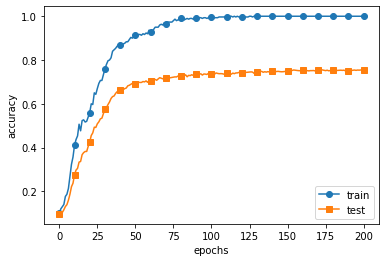

In [87]:
plt.plot(range(0, 201), train_acc_list, marker="o", markevery=10)
plt.plot(range(0, 201), test_acc_list, marker="s", markevery=10)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend(("train", "test"), loc="lower right")
plt.show()

### 6.4.2 가중치 감소(weigth decay)

- 큰 가중치에 대해서는 그에 상응하는 큰 페널티를 부과하여 오버피팅 억제
- 손실함수에 L2 노름을 더해서 가중치가 커지는 것을 억제
    - L2 이외에 L1, L$\infty$ 노름을 정규화 항으로 사용할 수 있다.
- 손실함수에 $\frac 1 2 \lambda \mathbf{W}^2$를 더한다.
    - $\lambda$: 정규화 세기 조절하는 하이퍼파라미터
    - $\frac 1 2$: 미분 결과인 $\lambda \mathbf{W}$을 조정하는 역할의 상수

epoch:0, train acc:0.13333333333333333, test acc:0.1115
epoch:1, train acc:0.13333333333333333, test acc:0.1129
epoch:2, train acc:0.14333333333333334, test acc:0.1168
epoch:3, train acc:0.16666666666666666, test acc:0.127
epoch:4, train acc:0.19, test acc:0.1384
epoch:5, train acc:0.23666666666666666, test acc:0.1571
epoch:6, train acc:0.31, test acc:0.186
epoch:7, train acc:0.36666666666666664, test acc:0.2196
epoch:8, train acc:0.4033333333333333, test acc:0.2419
epoch:9, train acc:0.43333333333333335, test acc:0.2831
epoch:10, train acc:0.47, test acc:0.306
epoch:11, train acc:0.5066666666666667, test acc:0.3287
epoch:12, train acc:0.5, test acc:0.3483
epoch:13, train acc:0.54, test acc:0.3697
epoch:14, train acc:0.54, test acc:0.3807
epoch:15, train acc:0.56, test acc:0.4008
epoch:16, train acc:0.5833333333333334, test acc:0.4183
epoch:17, train acc:0.5933333333333334, test acc:0.4193
epoch:18, train acc:0.6166666666666667, test acc:0.4395
epoch:19, train acc:0.6366666666666667, t

epoch:162, train acc:0.9133333333333333, test acc:0.7284
epoch:163, train acc:0.9233333333333333, test acc:0.7268
epoch:164, train acc:0.92, test acc:0.7277
epoch:165, train acc:0.9166666666666666, test acc:0.7282
epoch:166, train acc:0.92, test acc:0.7265
epoch:167, train acc:0.92, test acc:0.7228
epoch:168, train acc:0.9233333333333333, test acc:0.7271
epoch:169, train acc:0.9233333333333333, test acc:0.7234
epoch:170, train acc:0.93, test acc:0.7303
epoch:171, train acc:0.93, test acc:0.7266
epoch:172, train acc:0.93, test acc:0.7308
epoch:173, train acc:0.9366666666666666, test acc:0.7279
epoch:174, train acc:0.9333333333333333, test acc:0.727
epoch:175, train acc:0.9233333333333333, test acc:0.7235
epoch:176, train acc:0.9233333333333333, test acc:0.7301
epoch:177, train acc:0.94, test acc:0.7309
epoch:178, train acc:0.9333333333333333, test acc:0.7273
epoch:179, train acc:0.9233333333333333, test acc:0.7245
epoch:180, train acc:0.92, test acc:0.7208
epoch:181, train acc:0.9366666

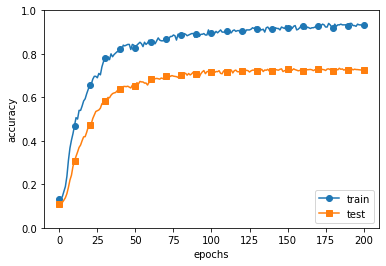

In [88]:
# coding: utf-8
import os
import sys

sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.multi_layer_net import MultiLayerNet
from common.optimizer import SGD

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

# 오버피팅을 재현하기 위해 학습 데이터 수를 줄임
x_train = x_train[:300]
t_train = t_train[:300]

# weight decay（가중치 감쇠） 설정 =======================
#weight_decay_lambda = 0 # weight decay를 사용하지 않을 경우
weight_decay_lambda = 0.1
# ====================================================

network = MultiLayerNet(input_size=784, hidden_size_list=[100, 100, 100, 100, 100, 100], output_size=10,
                        weight_decay_lambda=weight_decay_lambda)
optimizer = SGD(lr=0.01) # 학습률이 0.01인 SGD로 매개변수 갱신

max_epochs = 201
train_size = x_train.shape[0]
batch_size = 100

train_loss_list = []
train_acc_list = []
test_acc_list = []

iter_per_epoch = max(train_size / batch_size, 1)
epoch_cnt = 0

for i in range(1000000000):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]

    grads = network.gradient(x_batch, t_batch)
    optimizer.update(network.params, grads)

    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)

        print("epoch:" + str(epoch_cnt) + ", train acc:" + str(train_acc) + ", test acc:" + str(test_acc))

        epoch_cnt += 1
        if epoch_cnt >= max_epochs:
            break


# 그래프 그리기==========
markers = {'train': 'o', 'test': 's'}
x = np.arange(max_epochs)
plt.plot(x, train_acc_list, marker='o', label='train', markevery=10)
plt.plot(x, test_acc_list, marker='s', label='test', markevery=10)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()


여전히 차이는 있지만 이전과 비교하면 차이가 줄어들었다.

### 6.4.3 드롭아웃(dropout)

- 은닉층의 뉴런을 임의로 삭제하면서 학습하는 방법
- 시험 때는 각 뉴런의 출력에 훈련 때 삭제 안 한 비율을 곱하여 출력

<img src="https://mblogthumb-phinf.pstatic.net/MjAxNzA3MjdfMjEz/MDAxNTAxMTMzMzE4MDAz.ZAl6mcZ7VvWhLR82U6dovtoNeLbbmFHCGupK5hcJICAg.Z0wpOnQUwMLHuddn3XdFhgT-ghnzT8NHzZMbB4pFWcIg.PNG.cjswo9207/fig_6-22.png?type=w2">

In [89]:
class Dropout:
    
    def __init__(self, dropout_ratio=0.5):
        self.dropout_ratio = dropout_ratio
        self.mask = None
        
    
    def forward(self, x, train_flg=True):
        if train_flg:
            self.mask = np.random.rand(*x.shape) > self.dropout_ratio
            return x * self.mask
        else:
            return x * (1.0 - self.dropout_ratio)
        
        
    def backward(self, dout):
        return dout * self,mask

- self.mask: 삭제할 뉴런을 False로 표시
- 순전파 때 통과시키는 뉴런은 역전파 때도 신호를 그대로 통과시키고, 순전파 때 통과시키지 않은 뉴런은 역전파 때도 신호를 차단

train loss:2.309491224155422
=== epoch:1, train acc:0.08, test acc:0.1163 ===
train loss:2.328006200135542
train loss:2.319265995859929
train loss:2.309233560583923
=== epoch:2, train acc:0.09, test acc:0.1194 ===
train loss:2.3198595662256856
train loss:2.330303265673666
train loss:2.2917595119192704
=== epoch:3, train acc:0.09666666666666666, test acc:0.1232 ===
train loss:2.3112790740408657
train loss:2.304447933032519
train loss:2.2993112231102315
=== epoch:4, train acc:0.09666666666666666, test acc:0.1254 ===
train loss:2.307339342328266
train loss:2.309612617042189
train loss:2.314604201365074
=== epoch:5, train acc:0.09333333333333334, test acc:0.1288 ===
train loss:2.3031221182392176
train loss:2.3159352006549723
train loss:2.300970897200371
=== epoch:6, train acc:0.1, test acc:0.1299 ===
train loss:2.2942520675272284
train loss:2.293401140330743
train loss:2.3001587078681887
=== epoch:7, train acc:0.1, test acc:0.1315 ===
train loss:2.301932575751221
train loss:2.3139215530387

=== epoch:57, train acc:0.30333333333333334, test acc:0.2355 ===
train loss:2.223099404092291
train loss:2.205416488517986
train loss:2.1943742660081615
=== epoch:58, train acc:0.29, test acc:0.2301 ===
train loss:2.1994726950180965
train loss:2.2163328257737716
train loss:2.1880634690224157
=== epoch:59, train acc:0.2966666666666667, test acc:0.2278 ===
train loss:2.2065439518037686
train loss:2.2164151256882483
train loss:2.182252158558782
=== epoch:60, train acc:0.30333333333333334, test acc:0.2341 ===
train loss:2.1655303382894906
train loss:2.220969743250693
train loss:2.2313430912077674
=== epoch:61, train acc:0.31333333333333335, test acc:0.2389 ===
train loss:2.228526641458683
train loss:2.1984873197644546
train loss:2.2078186459128153
=== epoch:62, train acc:0.31666666666666665, test acc:0.2433 ===
train loss:2.20440944626035
train loss:2.200786730324269
train loss:2.177562660373594
=== epoch:63, train acc:0.31666666666666665, test acc:0.2467 ===
train loss:2.154116180629041
t

=== epoch:113, train acc:0.33666666666666667, test acc:0.2765 ===
train loss:2.0697863568639705
train loss:2.0345802778487414
train loss:2.0988293212516167
=== epoch:114, train acc:0.33666666666666667, test acc:0.2779 ===
train loss:2.0120179633012687
train loss:2.08597638813086
train loss:2.0530174141549704
=== epoch:115, train acc:0.3466666666666667, test acc:0.2794 ===
train loss:2.0105265612520036
train loss:2.0982286809716957
train loss:2.1010791790431207
=== epoch:116, train acc:0.35, test acc:0.2826 ===
train loss:2.1312140232256764
train loss:2.0703869313872065
train loss:1.903241675410451
=== epoch:117, train acc:0.35, test acc:0.2825 ===
train loss:2.0926957515326876
train loss:1.967939307314912
train loss:1.9823829395770236
=== epoch:118, train acc:0.36333333333333334, test acc:0.2841 ===
train loss:2.0024514638569935
train loss:2.0008050801718853
train loss:2.0292810352780997
=== epoch:119, train acc:0.35333333333333333, test acc:0.2829 ===
train loss:1.952007624804394
trai

=== epoch:168, train acc:0.43666666666666665, test acc:0.3299 ===
train loss:1.754641644308883
train loss:1.8399851419345539
train loss:1.7633371690358612
=== epoch:169, train acc:0.44, test acc:0.3311 ===
train loss:1.8364217976588608
train loss:1.897888092452478
train loss:1.7550973041485423
=== epoch:170, train acc:0.44333333333333336, test acc:0.3345 ===
train loss:1.813221795680907
train loss:1.8535773796470338
train loss:1.7065849809618259
=== epoch:171, train acc:0.44666666666666666, test acc:0.336 ===
train loss:1.7591382399651854
train loss:1.8273910729152423
train loss:1.8011771864093484
=== epoch:172, train acc:0.44333333333333336, test acc:0.3387 ===
train loss:1.7704861845937279
train loss:1.8569876008003612
train loss:1.8155913473856955
=== epoch:173, train acc:0.44333333333333336, test acc:0.3413 ===
train loss:1.7370068905346714
train loss:1.7011746327117447
train loss:1.823617082090276
=== epoch:174, train acc:0.44666666666666666, test acc:0.3414 ===
train loss:1.77421

=== epoch:223, train acc:0.52, test acc:0.4092 ===
train loss:1.5190874614828147
train loss:1.4883957901494387
train loss:1.607532667470751
=== epoch:224, train acc:0.51, test acc:0.4068 ===
train loss:1.4438445582969277
train loss:1.429126159805667
train loss:1.5574524525406266
=== epoch:225, train acc:0.5133333333333333, test acc:0.4061 ===
train loss:1.5220609658499538
train loss:1.5347527682797975
train loss:1.3673074502740095
=== epoch:226, train acc:0.5133333333333333, test acc:0.4096 ===
train loss:1.652800677419006
train loss:1.5014500350302153
train loss:1.6017384588998373
=== epoch:227, train acc:0.5133333333333333, test acc:0.4113 ===
train loss:1.5382219910589792
train loss:1.5792268842090875
train loss:1.4903090621847812
=== epoch:228, train acc:0.5233333333333333, test acc:0.4124 ===
train loss:1.5858304788085005
train loss:1.5468015454766109
train loss:1.4302056983691733
=== epoch:229, train acc:0.5166666666666667, test acc:0.4124 ===
train loss:1.571583102320655
train l

=== epoch:278, train acc:0.6566666666666666, test acc:0.4939 ===
train loss:1.303115444610805
train loss:1.2919920616070788
train loss:1.2411039431868465
=== epoch:279, train acc:0.6566666666666666, test acc:0.4969 ===
train loss:1.190376360454537
train loss:1.269051930299805
train loss:1.2924133319038622
=== epoch:280, train acc:0.65, test acc:0.4917 ===
train loss:1.1681882398231265
train loss:1.296431570634397
train loss:1.3075978783374298
=== epoch:281, train acc:0.66, test acc:0.4954 ===
train loss:1.1726303953625854
train loss:1.2607210196779204
train loss:1.3583999547840606
=== epoch:282, train acc:0.6633333333333333, test acc:0.4966 ===
train loss:1.248596725347647
train loss:1.2682337087128928
train loss:1.249128224191488
=== epoch:283, train acc:0.66, test acc:0.4987 ===
train loss:1.222226710468523
train loss:1.3545289774649754
train loss:1.2481460362399521
=== epoch:284, train acc:0.6666666666666666, test acc:0.5016 ===
train loss:1.1534165659887048
train loss:1.23625599669

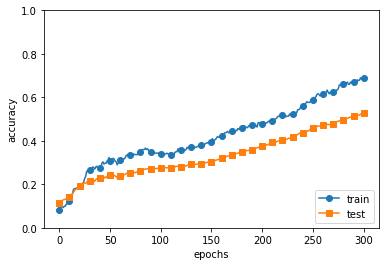

In [90]:
# coding: utf-8
import os
import sys
sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.multi_layer_net_extend import MultiLayerNetExtend
from common.trainer import Trainer

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

# 오버피팅을 재현하기 위해 학습 데이터 수를 줄임
x_train = x_train[:300]
t_train = t_train[:300]

# 드롭아웃 사용 유무와 비울 설정 ========================
use_dropout = True  # 드롭아웃을 쓰지 않을 때는 False
dropout_ratio = 0.2
# ====================================================

network = MultiLayerNetExtend(input_size=784, hidden_size_list=[100, 100, 100, 100, 100, 100],
                              output_size=10, use_dropout=use_dropout, dropout_ration=dropout_ratio)
trainer = Trainer(network, x_train, t_train, x_test, t_test,
                  epochs=301, mini_batch_size=100,
                  optimizer='sgd', optimizer_param={'lr': 0.01}, verbose=True)
trainer.train()

train_acc_list, test_acc_list = trainer.train_acc_list, trainer.test_acc_list

# 그래프 그리기==========
markers = {'train': 'o', 'test': 's'}
x = np.arange(len(train_acc_list))
plt.plot(x, train_acc_list, marker='o', label='train', markevery=10)
plt.plot(x, test_acc_list, marker='s', label='test', markevery=10)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

- 앙상블 학습: 개별적으로 학습시킨 여러 모델의 출력을 평균 내어 추론하는 방식
- 드롭아웃으로 앙상블과 유사한 효과를 낼 수 있다.

## 6.5 적절한 하이퍼파라미터 값 찾기

하이퍼파라미터
- 각 층의 뉴런 수
- 배치 크기
- 학습률
- 가중치 감소 등

### 6.5.1 검증 데이터

- 하이퍼파라미터의 성능을 평가할 때는 시험 데이터를 사용해선 안 된다.
    - 이유: 하이퍼파라미터 값이 시험 데이터에 오버피팅되기 때문
- **검증 데이터(validation data)**: 훈련 데이터에서 분리해서 하이퍼파라미터의 성능 평가

In [93]:
# coding: utf-8
import os
import sys
sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import numpy as np
from common.util import shuffle_dataset

In [94]:
(x_train, t_train), (x_test, t_test) = load_mnist()

# 훈련 데이터를 뒤섞는다.
x_train, t_train = shuffle_dataset(x_train, t_train)

# 20%를 검증 데이터로 분할
validation_rate = 0.20
validation_num = int(x_train.shape[0] * validation_rate)

x_val = x_train[:validation_num]
t_val = t_train[:validation_num]
x_train = x_train[validation_num:]
t_train = t_train[validation_num:]

- 데이터 분리 전에 입력 데이터와 정답 레이블을 뒤섞어야 한다. 데이터셋 안의 데이터가 치우쳐 있을 수도 있기 때문

### 6.5.2 하이퍼파라미터 최적화

- 그리드 서치보다 랜덤 서치가 더욱 좋은 결과를 낸다.
- 대략적인 범위를 설정하고 점차 줄여나간다. 로그 스케일로 지정

과정
- 0단계  
하이퍼파라미터 값의 범위를 설정한다.
- 1단계  
설정된 범위에서 하이퍼파라미터의 값을 무작위로 추출한다.
- 2단계  
1단계에서 샘플링한 하이퍼파라미터 값을 사용하여 학습하고, 검증 데이터로 정확도를 평가한다(에폭은 작게)
- 3단계  
1단계와 2단계를 특정 횟수 반복하며, 그 정확도의 결과를 보고 하이퍼파라미터의 범위를 좁힌다.

**베이즈 최적화(Bayesian optimization)**를 이용해서 효율적 최적화를 수행할 수 있다.

### 6.5.3 하이퍼파라미터 최적화 구현하기

학습률과 가중치 감소 계수 탐색하는 문제
- 가중치 감소 계수: $10^{-8}$~$10^{-4}$
- 학습률: $10^{-6}$~$10^{-2}$

In [ ]:
# coding: utf-8
import sys, os
sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.multi_layer_net import MultiLayerNet
from common.util import shuffle_dataset
from common.trainer import Trainer

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

# 결과를 빠르게 얻기 위해 훈련 데이터를 줄임
x_train = x_train[:500]
t_train = t_train[:500]

# 20%를 검증 데이터로 분할
validation_rate = 0.20
validation_num = int(x_train.shape[0] * validation_rate)
x_train, t_train = shuffle_dataset(x_train, t_train)
x_val = x_train[:validation_num]
t_val = t_train[:validation_num]
x_train = x_train[validation_num:]
t_train = t_train[validation_num:]


def __train(lr, weight_decay, epocs=50):
    network = MultiLayerNet(input_size=784, hidden_size_list=[100, 100, 100, 100, 100, 100],
                            output_size=10, weight_decay_lambda=weight_decay)
    trainer = Trainer(network, x_train, t_train, x_val, t_val,
                      epochs=epocs, mini_batch_size=100,
                      optimizer='sgd', optimizer_param={'lr': lr}, verbose=False)
    trainer.train()

    return trainer.test_acc_list, trainer.train_acc_list


# 하이퍼파라미터 무작위 탐색======================================
optimization_trial = 100
results_val = {}
results_train = {}
for _ in range(optimization_trial):
    # 탐색한 하이퍼파라미터의 범위 지정===============
    weight_decay = 10 ** np.random.uniform(-8, -4)
    lr = 10 ** np.random.uniform(-6, -2)
    # ================================================

    val_acc_list, train_acc_list = __train(lr, weight_decay)
    print("val acc:" + str(val_acc_list[-1]) + " | lr:" + str(lr) + ", weight decay:" + str(weight_decay))
    key = "lr:" + str(lr) + ", weight decay:" + str(weight_decay)
    results_val[key] = val_acc_list
    results_train[key] = train_acc_list

=========== Hyper-Parameter Optimization Result ===========
Best-1(val acc:0.78) | lr:0.0077307054058675445, weight decay:2.5887086671429946e-05
Best-2(val acc:0.77) | lr:0.009154370132240392, weight decay:8.379491394743663e-05
Best-3(val acc:0.76) | lr:0.0098006673797611, weight decay:1.0450027144308723e-07
Best-4(val acc:0.72) | lr:0.007678681706710489, weight decay:1.7836457077216995e-07
Best-5(val acc:0.71) | lr:0.007626052918778914, weight decay:4.5307674366432563e-07
Best-6(val acc:0.65) | lr:0.004922531472247901, weight decay:1.7303188009642406e-07
Best-7(val acc:0.6) | lr:0.004816515317994456, weight decay:4.499890310553459e-07
Best-8(val acc:0.58) | lr:0.003990354694316797, weight decay:1.8853665087085003e-06
Best-9(val acc:0.55) | lr:0.0035304311414633004, weight decay:2.637284630879835e-07
Best-10(val acc:0.49) | lr:0.0030944498698391794, weight decay:8.008827389280176e-08
Best-11(val acc:0.48) | lr:0.0033599550676127856, weight decay:5.599030526130115e-07
Best-12(val acc:0.

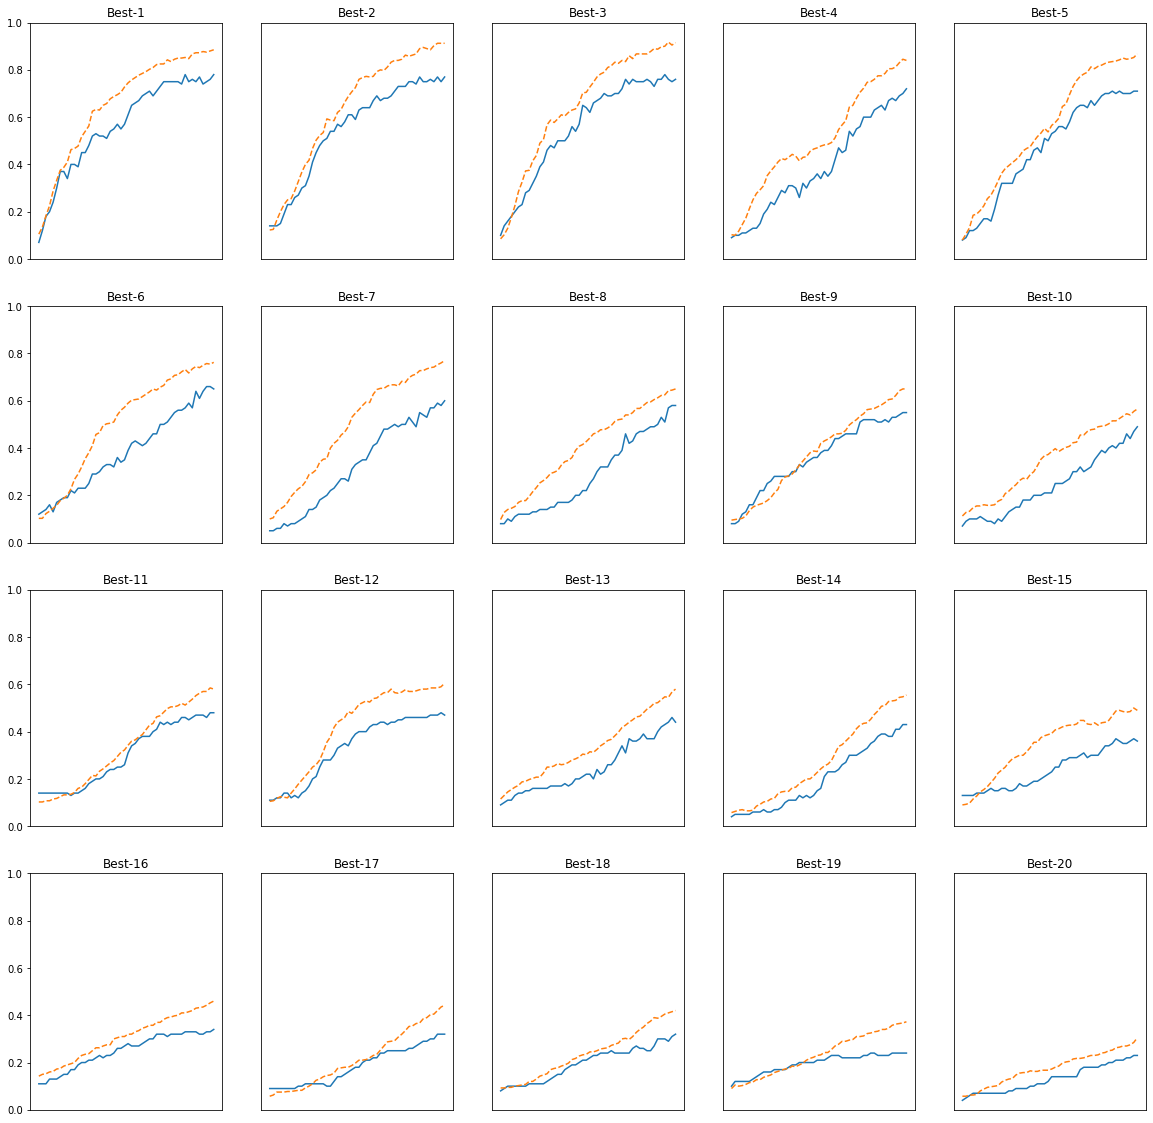

In [97]:
# 그래프 그리기========================================================
print("=========== Hyper-Parameter Optimization Result ===========")
graph_draw_num = 20
col_num = 5
row_num = int(np.ceil(graph_draw_num / col_num))
i = 0

plt.figure(figsize=(20,20))
for key, val_acc_list in sorted(results_val.items(), key=lambda x:x[1][-1], reverse=True):
    print("Best-" + str(i+1) + "(val acc:" + str(val_acc_list[-1]) + ") | " + key)

    plt.subplot(row_num, col_num, i+1)
    plt.title("Best-" + str(i+1))
    plt.ylim(0.0, 1.0)
    if i % 5: plt.yticks([])
    plt.xticks([])
    x = np.arange(len(val_acc_list))
    plt.plot(x, val_acc_list)
    plt.plot(x, results_train[key], "--")
    i += 1

    if i >= graph_draw_num:
        break

plt.show()

학습률은 $0.001$ ~ $0.01$, 가중치 감소 계수는 $10^{-8}$ ~ $10^{-6}$ 사이에서 학습이 잘 진행된다.